In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = open('warpeace_input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

class DataReader:
    def __init__(self, path, seq_length):
        self.fp = open(path, "r")
        self.data = self.fp.read()
        vocab = list(set(self.data))
        self.char_to_ix = {ch:i for (i,ch) in enumerate(vocab)}
        self.ix_to_char = {i:ch for (i,ch) in enumerate(vocab)}
        self.data_size = len(self.data)
        self.vocab_size = len(vocab)
        self.pointer = 0
        self.seq_length = seq_length

    def next_batch(self):
        input_start = self.pointer
        input_end = self.pointer + self.seq_length
        inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
        targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
        self.pointer += self.seq_length
        
        # reset pointer
        if self.pointer + self.seq_length + 1 >= self.data_size:
            input_start = self.pointer
            input_end = self.data_size
            inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
            targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
            self.pointer = self.data_size
        return inputs, targets

    def just_started(self):
        return self.pointer == 0

    def epoch_end(self):
        return self.pointer == self.data_size

    
    def close(self):
        self.fp.close()

data has 3196213 characters, 83 unique.


In [452]:
class F:
    def softmax(x):
        """Compute softmax values for each sets of scores in x.

        Subtracts max(x) for numerical stability
        Args:
            x: an array of size n * 1.
        Returns:
            A probability distribution over the vector x
        """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    def crossentropy(pred_prob, target):
        return sum(-np.log(pred_prob[t][target[t],0]) for t in range(len(pred_prob.keys())))


class RNN:
    def __init__(self, num_hidden, num_input):
        self.input_size = num_input
        self.W_hx = np.random.randn(num_hidden, num_input)*0.01 # input to hidden of dimension hidden * input
        self.W_hh = np.random.randn(num_hidden, num_hidden)*0.01 # hidden to hidden of dimension hidden * hidden
        self.W_hy = np.random.randn(num_input, num_hidden)*0.01 # hidden to output of dimension input * hidden
        
        self.b_h = np.zeros((num_hidden, 1)) # hidden bias of dimension hidden * 1
        self.b_y = np.zeros((num_input, 1)) # output bias of dimension input * 1

        self.h = np.random.randn(num_hidden,1) * 0.01
        
        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.W_hx)
        self.mWhh = np.zeros_like(self.W_hh)
        self.mWhy = np.zeros_like(self.W_hy)
        self.mbh = np.zeros_like(self.b_h)
        self.mby = np.zeros_like(self.b_y)

        
    def step(self, x):
        """Compute a single step using hidden states for a given x.
        Computes three dictionaries x_hat, h, p with keys = timestep
        
        
        Mathematically it is h(t) = tanh((Wh * h(t-1)) + (Wx *x) + bias)
                             y = Wy * h + bias
        Args:
            x: a vector of size n * 1.
        Returns:
            x_hat: a dictionary of one hot vectors of input for each time step
            h: a dictionary of hidden states of each time step
            p: Predicted probabilities of each timestep
        """
        h, y_hat, x_hat, p = {}, {}, {}, {}
        h[-1] = np.zeros(self.h.shape)

        for t in range(len(x)):
            x_hat[t] = np.zeros((self.input_size,1)) # Convert x into 1-hot-vector
            x_hat[t][x[t]] = 1 # Set the index x[t] of 1-hot-vector x_hat[t] to 1
            h[t] = np.tanh(np.dot(self.W_hh, h[t-1]) + np.dot(self.W_hx, x_hat[t]) + self.b_h)
            y_hat[t] = np.dot(self.W_hy, h[t]) + self.b_y
            p[t] = F.softmax(y_hat[t])
        return x_hat, h, p
    
    
    def backward(self, x, y, p, h, clip_val=5):
        """Backpropogates through a sequence

        Args:
            x: a dictionary of one hot vectors of input for each time step
            y: vector containing real output values of dimension n*1
            p: a dictionary of predicted probabilities
            h: a dictionary of hidden states
            clip_val: Clip values of gradient so it doesn't explode
        Returns:
            dW_hx, dW_hh, dW_hy, db_h, db_y: derivatives of weight vectors and bias
        """

        dW_hx = np.zeros_like(self.W_hx)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        dh_next = np.zeros_like(self.h)

        for t in reversed(range(len(x))):
            #backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dy = np.copy(p[t])
            dy[y[t]] -= 1

            #find updates for y
            dW_hy += np.dot(dy, h[t].T)
            db_y += dy

            #backprop into h and through tanh nonlinearity
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_raw = (1 - h[t]**2) * dh

            #find updates for h
            dW_hx += np.dot(dh_raw, x[t].T)
            dW_hh += np.dot(dh_raw, h[t-1].T)
            db_h += dh_raw

            #save dh_next for subsequent iteration
            dh_next = np.dot(self.W_hh.T, dh_raw)
            
        # clip to mitigate exploding gradients
        for dparam in [dW_hx, dW_hh, dW_hy, db_h, db_y]:
            np.clip(dparam, -clip_val, clip_val, out=dparam) 
        return dW_hx, dW_hh, dW_hy, db_h, db_y
 
    
    def sgd(self, dWxh, dWhh, dWhy, dbh, dby, learning_rate=1e-1):
        """Updates weights with vanilla gradient descent

        Args:
            dW_hx, dW_hh, dW_hy, db_h, db_y: derivatives of weight vectors and bias
            learning_rate: Learning Rate for SGD
        """
        for param, dparam in zip([self.W_hx, self.W_hh, self.W_hy, self.b_h, self.b_y],
                                  [dWxh, dWhh, dWhy, dbh, dby]):
            param += -learning_rate * dparam

    def adagrad(self, dWxh, dWhh, dWhy, dbh, dby, learning_rate=1e-1):
        """Updates weights with adagrad

        Args:
            dW_hx, dW_hh, dW_hy, db_h, db_y: derivatives of weight vectors and bias
            learning_rate: Learning Rate for Adagrad
        """
        # parameter update with adagrad
        for param, dparam, mem in zip([self.W_hx, self.W_hh, self.W_hy, self.b_h, self.b_y],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [self.mWxh, self.mWhh, self.mWhy, self.mbh, self.mby]):
            mem += dparam*dparam
            param += -learning_rate*dparam/np.sqrt(mem+1e-8) # adagrad update

    def train(self, x, y, optimizer="sgd", lr = 1e-3):
        """The train function which does the following computation in order
            1. Calls step(x) i.e traverses through one sequence
            2. Gets loss of predicted values from previous step
            3. Computes gradients using backward()
            4. Updates weight vectors using our choice of optimizer
            5. Sets the hidden state to last hidden state

        Args:
            dW_hx, dW_hh, dW_hy, db_h, db_y: derivatives of weight vectors and bias
            optimizer: sgd or adagrad
            lr: Learning Rate for SGD
        
        Returns:
            curr_loss: Cross Entropy loss of our step(x)
        """
        loss = 0
        x_one_hot, hidden_states, pred_prob = self.step(x)
        curr_loss = F.crossentropy(pred_prob, y)
        dW_hx, dW_hh, dW_hy, db_h, db_y = self.backward(x_one_hot, y, pred_prob, hidden_states)
        if optimizer == "sgd":
            self.sgd(dW_hx, dW_hh, dW_hy, db_h, db_y, learning_rate=lr)
        elif optimizer == "adagrad":
            self.adagrad(dW_hx, dW_hh, dW_hy, db_h, db_y, learning_rate=lr)
            
        self.h = hidden_states[len(pred_prob)-1]
        return curr_loss

    
    
    def forward(self, seed, n):
        """ 
        Do one forward pass, with the starting character as seed
        h is memory state, seed is seed letter for first time step
        
        Args:
            seed: index of first character for time step
            n : size of sequence (time steps)
        Returns:
            predicted_index: a vector of size n with predicted_indexes for timestep t + 1
        """
        
        x = np.zeros((self.input_size, 1))
        x[seed] = 1
        predicted_indexes = []
        for t in range(n):
            h = np.copy(self.h)
            h = np.tanh(np.dot(self.W_hh, h) + np.dot(self.W_hx, x) + self.b_h)
            y = np.dot(self.W_hy, h) + self.b_y
            p = F.softmax(y)
            predicted_char = np.random.choice(range(self.input_size), p=p.ravel())
            x = np.zeros((self.input_size, 1))
            x[predicted_char] = 1
            predicted_indexes.append(predicted_char)
        return predicted_indexes

    def show_weight(self):
        print(self.h)


In [453]:
sequence_length = 25
epochs = 10
batches = int(len(data)/sequence_length)
rnn = RNN(10, vocab_size)
losses = []
smooth_loss = -np.log(1.0/vocab_size)*sequence_length
losses.append(smooth_loss)
data_reader = DataReader("warpeace_input.txt", sequence_length)
for epoch in range(epochs):
    counter = 0
    while(data_reader.epoch_end):
        counter += 1
        inputs, targets = data_reader.next_batch()
        rnn.train(inputs, targets)
        if counter%1000 == 999:
            pred_x = rnn.forward(inputs[0], 50)
            txt_x = ''.join([ix_to_char[n] for n in pred_x])
            txt_y = ''.join([ix_to_char[n] for n in y])    
            print(epoch, counter+1, losses[-1])
            print(txt_x)
        loss = rnn.train(x,y,optimizer="adagrad",lr=0.1)
        smooth_loss = smooth_loss*0.999 + loss*0.001
        losses.append(smooth_loss)

0 1000 41.883376713900375
CR M sa hwnd abdd lenddiimd ee a ?R2"ta=/leey a
ls
0 2000 15.726908296091413
 ahi nd d 3gw awrre o a!se i aia
ekaa
d fipnd nd d
0 3000 6.1942893340048455
 ä wiév o  ad tnêe a
 g o ad Ne ;hXo at adirova
a

0 4000 2.6596492763197492
t adPpt indi oddotoieNe rgi hemt
 ewd Soaiad l/ ad
0 5000 1.3791331478309143
ed w ssoo in e ad *i orOw s lb  n End po ebwrero a


KeyboardInterrupt: 

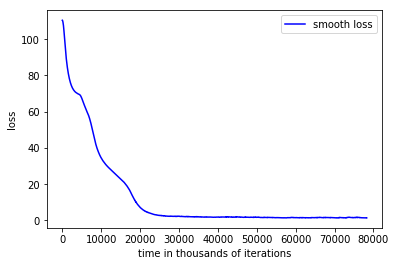

In [444]:
plt.plot(range(len(losses)), losses, 'b', label='smooth loss')
plt.xlabel('time in thousands of iterations')
plt.ylabel('loss')
plt.legend()
plt.show()
